# Outline

**[Introduction](#introduction)**
- Research Question
- Project goal

**[Data Preprocessing](#data-preprocessing)**
- [Cleaning data](#cleaning-the-data): [Handling mistakes](#handling-mistakes), [outliers](#outliers)
- [Visualization](#visualization)
- [Encoding](#encoding), [splitting data and standardization](#splitting-data-and-standardization)

**[Model Building](#model-building)**
- [Logistic Regression](#logistic-regression) model + evaluation
- [Decision Tree](#decision-tree) model + evaluation

**[Conclusion](#conclusion)*
- Which model performs better

**[References](#references)**

# Introduction
The purpose of this project is to build and evaluate machine learning models that classify fruits (apples, bananas, grapes) based on their features such as color, size and weight.  
This task reflects a typical supervised classification problem: the model is trained on labeled data and then evaluated on its ability to classify new data.
The goals of this project are:
- To train and compare two classification models, Logistic Regression and Decision Tree.
- To showcase a transparent and structured workflow, including methodology.


In [120]:
# import basic libraries
import pandas as pd 
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier


# Data Preprocessing
## Cleaning the data
At first, we read the data from the excel file and take a look at its structure. The dataset contains two columns specifying indices, the duplicate needs to be removed, as it is redundant information and has no predictive value for machine learning. After that, a check for null values is performed, to ensure a complete dataset. This dataset contains none, so no action is necessary.

In [75]:
# Read data from excel file and save as dataframe
df = pd.read_excel('../data/fruit_data.xlsx')
df.head()


,Unnamed: 0,fruit_type,color,size,weight
0,0,grape,Yellow,Tiny,8.303385
1,1,apple,Pink,Largee,80.976370
2,2,banana,Pale Yellow,Large,74.615192
3,3,grape,Red,Tiny,6.924070
4,4,banana,Creamy White,Largee,82.002542


In [76]:
# Drop unnamed column, as indeces are already saved in dataframe
df.drop(columns=['Unnamed: 0'], inplace=True)
# Check for null values (can also be seen in df.info())
df.isnull().sum()

fruit_type    0
color         0
size          0
weight        0
dtype: int64

Now there are four columns left, fruit_type (the value to be predicted later), color and size, both as String objects and weight as a floating point number. It is assumed that the unit for weight is grams, as this would be most plausible for the given weights and fruits. Ounces and kilograms would be too heavy and milligrams too light.

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fruit_type  200 non-null    object 
 1   color       200 non-null    object 
 2   size        200 non-null    object 
 3   weight      200 non-null    float64
dtypes: float64(1), object(3)
memory usage: 6.4+ KB


The fruit types are balanced, that means that the model will not be biased towards one of the fruit types and no countermeasures like oversampling or undersampling are necessary.

In [78]:
# Check distribution of fruit types
df['fruit_type'].value_counts()

fruit_type
apple     70
grape     66
banana    64
Name: count, dtype: int64

### Handling Mistakes
In this case the dataset is relatively small and mistakes can be spotted by examining the data. To speed up this process, the unique values for each column were reviewed to find potential duplicates or inconsistencies. In a dataset that has too many different values for each column, e.g. demographic data for an entire city, a different approach is required. Like identifying low frequency values, strings with numbers in text fields or applying fuzzy string matching using libraries such as fuzzywuzzy.

In [79]:
# Look at possible fruit colors to find mistakes
unique_colors = df['color'].unique()
print(unique_colors)
# The dataset contains both 'Yellow' and 'Yellow1', therefore we replace the typo with the correct value
df['color'] = df['color'].replace({'Yellow1':'Yellow'})

['Yellow' 'Pink' 'Pale Yellow' 'Red' 'Creamy White' 'Green' 'Yellow1'
 'Purple' 'Black']


In [80]:
# Look at possible fruit sizes to find mistakes
unique_sizes = df['size'].unique()
print(unique_sizes)
# The dataset contains 'Large' and the typo 'Largee' which needs to be replaced
df['size'] = df['size'].replace({'Largee':'Large'})

['Tiny' 'Largee' 'Large' 'Small' 'Medium']


In [81]:
# Look at possible fruit types to find mistakes
unique_fruit = df['fruit_type'].unique()
print(unique_fruit)
# Labels do not contain typos

['grape' 'apple' 'banana']


### Outliers
In order to identify outliers, a general overview over the data is needed. It becomes apparent that the minimum weight is 1.0 and the maximum is 250.0. At first this may seem suspicious, but considering that the possible fruits range from very light fruits like grape to heavier fruits like bananas, the outliers cannot be determined by the overall weight distribution alone. Consequently, the data of the different fruit types has to be examined separately.

In [82]:
# General overview
df.describe()

,weight
count,200.000000
mean,59.047220
std,46.697739
min,1.000000
25%,8.142752
50%,63.109415
75%,94.367815
max,250.000000


Examining the statistics separated by fruit type, a few unusual values can already be spotted, as the minimum weight for an apple is roughly 8.3g and for a banana 27.7g. To further confirm the suspicion, boxplots of the weight distributions are helpful. Using seaborn, all three boxplots are visible without much configuration.

In [83]:
# Overview separated by fruit type
df.groupby("fruit_type")["weight"].describe()


,count,mean,std,min,25%,50%,75%,max
fruit_type,,,,,,,,
apple,70.0,93.720023,39.100208,8.300753,72.345856,92.585794,108.034470,250.000000
banana,64.0,74.908579,27.729121,26.524587,55.750320,77.121200,95.451442,116.380543
grape,66.0,6.892322,1.924690,1.000000,5.822353,6.461906,7.668747,10.902198


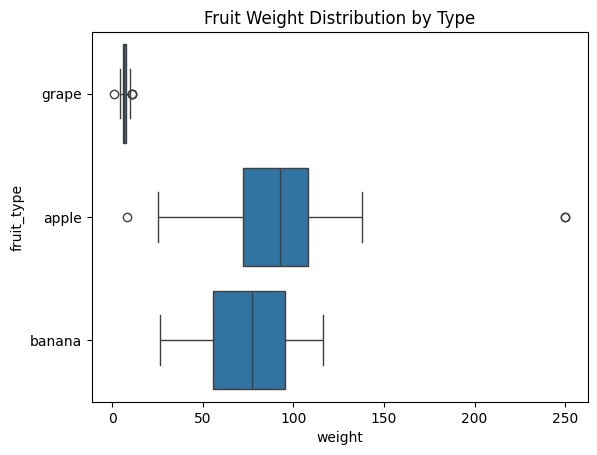

In [84]:
sns.boxplot(x="weight", y="fruit_type", data=df)
plt.title("Fruit Weight Distribution by Type")
plt.show()

In order to find the outliers, the Interquartile Range (IQR) method is used. For this, the difference between the weight at the first quartile (Q1) and at the third quartile (Q3) are calculated. The result multiplied by 1.5 is the limit for finding  outliers in both directions when added or subtracted to the first/third quartile. [1]   
As a result we get a dataframe only containing the possible outliers.

In [85]:
outliers = pd.DataFrame()

# iterate through the fruit types and create a subset for each
for fruit in df['fruit_type'].unique():
    subset = df[df['fruit_type'] == fruit]
    
    # 25th percentile
    Q1 = subset['weight'].quantile(0.25)
    # 75th percentile
    Q3 = subset['weight'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # values below or above 1.5 * Interquartile Range are outliers
    fruit_outliers = subset[
        (subset['weight'] < lower) | (subset['weight'] > upper)
    ]
    
    # If new outliers are found, add them to the dataframe
    outliers = pd.concat([outliers, fruit_outliers])

outliers

,fruit_type,color,size,weight
34,grape,Purple,Tiny,10.902198
37,grape,Yellow,Tiny,1.000000
138,grape,Green,Small,10.902198
192,grape,Green,Medium,10.902198
26,apple,Green,Small,250.000000
33,apple,Yellow,Medium,250.000000
175,apple,Green,Medium,8.300753


A few of the outliers (indices 37, 26, 33) have only zeroes after the decimal point. As this is quite unlikely and they are identified as outliers in the box plot, it is likely that they are measuring errors. A normal, medium sized apple (175) cannot weight 8.3g, making it probably a measuring fault. 
For the three unusually heavy grapes (34, 138, 192) the case is not as clear. At first, it may seem unusual that the grapes are all different sizes and have the same weight, but as we do not know where the data comes from it cannot be ruled out. E.g. if it came from a questionnaire without details for the size classification, each person could interpret the size of the same fruit differently, a grape could be small compared to a coconut and it could be large compared to smaller grapes at the same time. As the weight difference is not huge compared to other grapes in the set, that are not classified as outliers in the boxplot, and 10.9g is still realistic for a grape, these datapoints will not be removed from the dataset.  
The dataset contains other values that seem unlikely, like a banana weighing 27.7g, that are not identified as outliers using the IQR method, but as there is no other information about the fruit, e.g. if the fruits are fully grown, they will remain in the dataset.

In [86]:
# Index of the medium sized grape weighing 10.9g 
keep_index = [34,138,192]

# Get indices of all outliers except the one we want to keep
outliers_index = outliers.index.difference(keep_index)

# Remove the outliers from the dataframe
df_clean = df.drop(index=outliers_index)

Before continuing, the outliers and the cleaned data are saved as excel files, in case they need to be examined later and to make the different steps of data processing visible.

In [87]:
# Remove value that is kept in df_clean
outliers.drop(index=keep_index, inplace=True)

# Save outliers as excel file
outliers.to_excel('../data/fruit_outliers.xlsx')

# Save cleaned fruit_data as excel file
df_clean.to_excel('../data/fruit_data_clean.xlsx')


## Visualization
Data visualization helps to get a better knowledge of how the different features correlate with each other.  
Size and weight should correlate with each other, but in this case, no matter what size the fruit is, the weight range is quite similar.  
Bananas range from roughly 25g to 120 grams no matter the size, small apples range from ~40g to 140g, whereas large apples range from ~25g to 135g. Grapes also maintain the same range across sizes.  
Although it is visible, that grapes are always tiny, small or medium and apples/bananas are always small, medium or large, the sizes of the fruits do not offer reliable insight into their weight, as they are overlapping a lot between sizes.

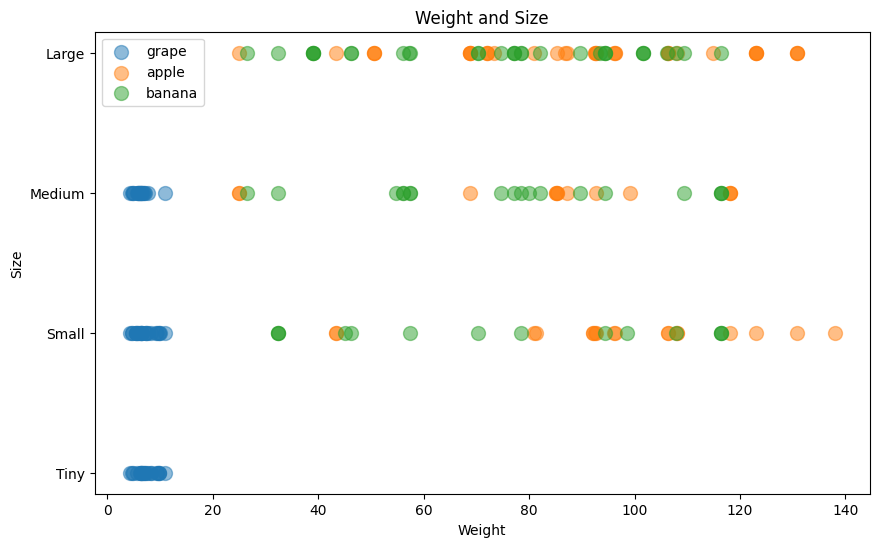

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for each fruit type
for fruit in df_clean['fruit_type'].unique():
    subset = df_clean[df_clean['fruit_type'] == fruit]
    ax.scatter(subset['weight'], subset['size'], 
               label=fruit, s=100, alpha=0.5)

ax.set_title('Weight and Size')
ax.set_xlabel('Weight')
ax.set_ylabel('Size')
ax.legend()
plt.show()

The color distribution for the fruits reveals that some colors are only associated with a certain fruit, allowing reliable predictions by color. E.g. pink is only seen in apples, creamy white and pale yellow only in bananas and purple and black only in grapes.  
But the other colors (red, green, yellow) are quite evenly distributed between all fruit types, making it impossible to predict a fruit by its color alone.

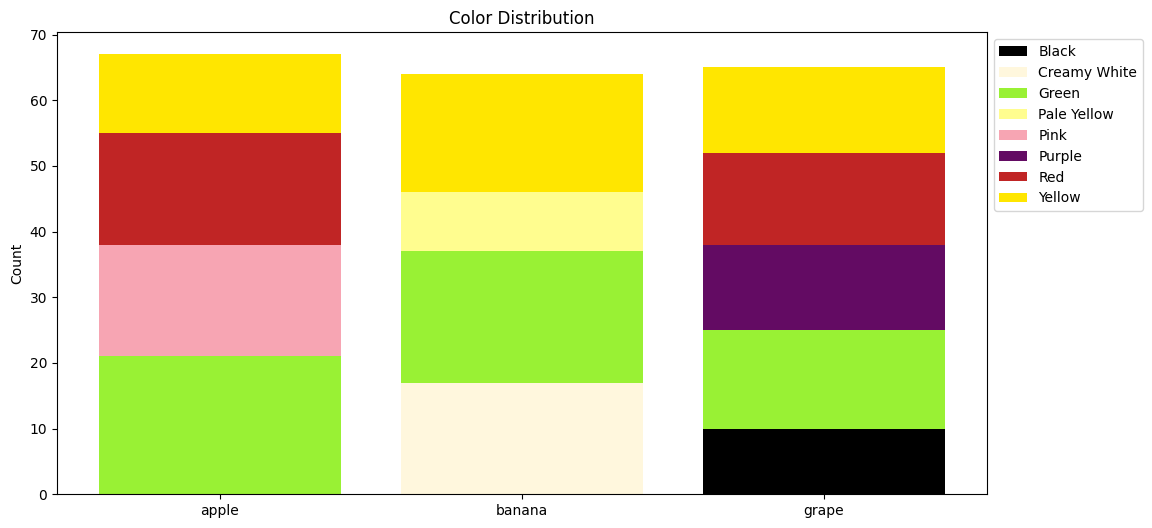

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))

cross_tab = pd.crosstab(df_clean['fruit_type'], df_clean['color'])

# start with a list of zeros as long as the count of fruit_types, alternative [0,0,0]
bottom = np.zeros(len(cross_tab.index))
colors = [
    '#000000',   # black
    '#FFF7DD',   # creamy white
    "#99F134",   # green
    '#FFFD8F',   # pale yellow
    "#F7A5B3",   # pink
    "#630B63",   # purple
    "#C02525",   # red
    "#FFE600"    # yellow
]

for i, color_type in enumerate(cross_tab.columns):
    ax.bar(cross_tab.index, cross_tab[color_type], bottom=bottom, 
           label=color_type, color=colors[i % len(colors)])
    bottom += cross_tab[color_type]

ax.set_ylabel('Count')
ax.set_title('Color Distribution')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## Encoding
As we need numerical data for logistic regression and we have two columns with categorical data, we need to encode them. Decision tree also works with categorical data, but because the two models will be compared later, it is best to use the same data for both to make the comparison accurate.  
First, 'color' needs to be encoded using One-Hot-Encoding, as there is no inherent order between colors. Mapping 'size' to numbers allows keeping the order the sizes have (small is bigger than tiny etc.).



In [90]:
df_encoded = df_clean[['fruit_type','weight']].copy()

# One-hot-encode the colors and add to df_encoded
color_encoded = pd.get_dummies(df_clean['color'], prefix='color', drop_first=True, dtype=int) # adding drop_first=True ro remove redundancy
df_encoded = pd.concat([df_encoded, color_encoded], axis=1)

# Map the sizes to numbers and add them to df_encoded
size_mapping = {'Tiny': 0, 'Small': 1, 'Medium': 2, 'Large': 3}
df_encoded['size_encoded'] = df_clean['size'].map(size_mapping)

df_encoded


,fruit_type,weight,color_Creamy White,color_Green,color_Pale Yellow,color_Pink,color_Purple,color_Red,color_Yellow,size_encoded
0,grape,8.303385,0,0,0,0,0,0,1,0
1,apple,80.976370,0,0,0,1,0,0,0,3
2,banana,74.615192,0,0,1,0,0,0,0,3
3,grape,6.924070,0,0,0,0,0,1,0,0
4,banana,82.002542,1,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...
195,grape,9.774546,0,0,0,0,1,0,0,1
196,banana,39.012962,0,0,1,0,0,0,0,3
197,grape,7.409021,0,0,0,0,0,1,0,1
198,grape,4.651554,0,0,0,0,0,1,0,2


As all of our features are now numeric, it is possible to generate a heatmap, showing that weight and size are somewhat correlated, but as already seen in the plots above, they are not reliably connected. 

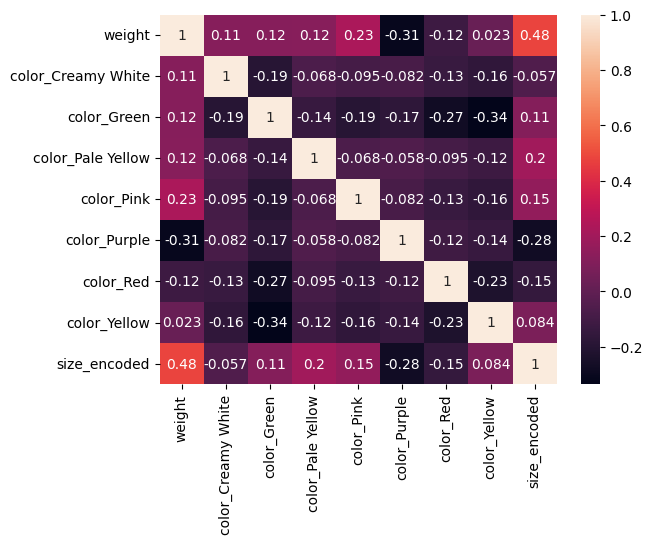

In [91]:
df_features = df_encoded.drop(columns='fruit_type')

sns.heatmap(df_features.corr(), annot = True);

## Splitting data and standardization
First, the target values (y) are separated from the predictors (X).

In [92]:
# Predictors
X = df_features
# Target values
y = df_encoded['fruit_type']

For Logistic Regression the weight column will be scaled, because it contains continuous values with a larger scale than the other columns. This could disproportionately influence the model and prevent/slow convergence. The other columns do not need to be scaled because they are already on a small and consistent scale, as they have been encoded before. 
The data is scaled using the Standard-Scaler, because the fixed range of the MinMax-Scaler is not needed and RobustScaler is not needed because outliers have already been removed.
As  Decision Tree makes splitting decisions based on feature value comparisons and thresholds rather than distance calculations or gradient descent, it is not relevant wether or not the data is scaled.

In [93]:
# Scale data
scaler = StandardScaler()

X_scaled = X.copy()

X_scaled[["weight"]] = scaler.fit_transform(X[["weight"]])

 Then the data is split into training and test data, in order to have some unseen data for the model to be evaluated on. [2]  
 Here, a fixed test set is used for final evaluation to ensure reproducibility, while cross-validation is performed only on the training set for hyperparameter tuning. This keeps the test set unseen until the final assessment. In real-world scenarios, relying on a single test set can be risky because small or unrepresentative splits may mislead performance estimates. 

In [94]:
# Splitting training and test data, random_state=1 so the split is reproducable,
# stratify=y to keep class distribution
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y) 

# Model Building
## Logistic Regression

### Training the model and choosing hyperparameters

First, the model is trained with the scaled data, delivering an accuracy of 0.8. The training failed using the unscaled data as the model failed to converge, proving the assumption above right. The cross-validation-score (the mean accuracy for all folds) is roughly 0.85.

In [95]:
# Create model
model_LR = LogisticRegression()

# Fit model to training data
model_LR.fit(X_train, y_train)

model_LR.score(X_test, y_test)

0.8

In [96]:
# Mean accuracy using cross validation
scores_LR = cross_val_score(model_LR, X_train, y_train, cv=5)
print(np.mean(scores_LR))

0.8465725806451612


In order to see if the model can improve its performance, a few hyperparameter combinations will be tested using GridSearch. For this 'liblinear' as a solver was excluded, because it does not handle multi_class problems, well, consequently 'dual' is not included, as it only works with liblinear. The grid is split by penalties, because most solvers are only compatible with L2 penalty. [3]    
To evaluate the models, accuracy is used, as the purpose of the fruit-classifier is not know (e.g. is it important that all apples are identified (recall for apples) etc.).
This reveals the parameters {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'} as the best, this will become the hyperparameters used for the Logistic Regression Model. 

In [97]:
# Define parameter grid
param_grid = [
    # L1 penalty
    {
        'penalty': ['l1'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [2000, 3000],      # Higher iterations because max_iter was reached before convergence
        'class_weight': [None, 'balanced'],
    },
    # L2 penalty  
    {
        'penalty': ['l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga', 'lbfgs', 'newton-cg'],
        'max_iter': [1000, 2000, 3000],
        'class_weight': [None, 'balanced'],
    },

    # Elasticnet penalty
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'max_iter': [2000, 3000],       # Higher iterations because max_iter was reached before convergence
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],  # Only used with elasticnet
        'class_weight': [None, 'balanced'],
    }
]

# Grid search
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Best score: 0.8721774193548386


### Evaluating the model
Testing the final model reveals that the accuracy increased (default: 0.8, final: 0.825), and an improvement in the cross-validation-score is visible (default: 0.8465725806451612, final: 0.8721774193548386). This proves the tuned model to be more accurate than the default.

In [98]:
final_model_LR = grid_search.best_estimator_

# Final evaluation on untouched test set
final_score_LR = final_model_LR.score(X_test, y_test)
print(f"Final test accuracy: {final_score_LR}")



Final test accuracy: 0.825


The classification report and confusion matrix reveal that the model is able to identify all grapes (recall 1.00) and predicts only two false positives (one apple and one banana). The precision is also the highest of them all, 87% of grape predictions are correct. For bananas, precision is 73%, while the recall is higher with 85%. That means 85% of all bananas are recognized as bananas, but there is some misclassification happening, as one banana was recognized as apple and one as grape. Apple had higher precision than banana, but overall less apples were correctly recognized as apples, only 64% of all actual apples. Four of them were recognized as bananas and one as grape. A reason for this could be, that as seen in the [visualizations](#visualization), apples and bananas are in the same weight range, no matter the size and both can be green or yellow. As grapes generally weigh a lot less, the prediction was more accurate. The f1-scores show that the model performs similarly moderate on apples and bananas. While the score for bananas is a little higher, grapes are classified more accurately (0.93).   
Although the current model achieves 0.825% overall accuracy, the moderate f1-scores for apples and bananas show, that the model has problems distinguishing these fruits based on weight, color and size. Having additional features like 'shape' could improve the model, as there would be little to no overlap, different to the existing features.

              precision    recall  f1-score   support

       apple       0.90      0.64      0.75        14
      banana       0.73      0.85      0.79        13
       grape       0.87      1.00      0.93        13

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.82        40
weighted avg       0.83      0.82      0.82        40



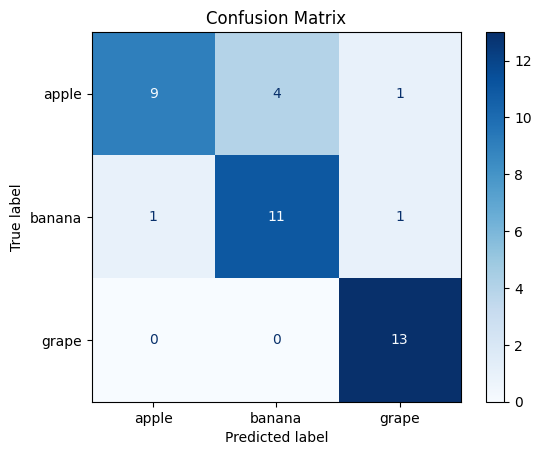

In [99]:
y_pred_LR = final_model_LR.predict(X_test)
print(classification_report(y_test, y_pred_LR))


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_LR)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model_LR.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

## Decision Tree
### Training the model and choosing hyperparameters
Although it does not matter wether the data is scaled or not for Decision Tree, the scaled data will be used so both models are trained with the same data. 

In [121]:
model_DT = DecisionTreeClassifier(random_state=1)

model_DT.fit(X_train, y_train)

y_pred_DT = model_DT.predict(X_test)

accuracy_score(y_test, y_pred_DT)

0.825

In [122]:
# Cross Validation
scores_DT = cross_val_score(model_DT, X_train, y_train, cv=5)
print(f"Cross-Validation-Score: {np.mean(scores_DT)}")

Cross-Validation-Score: 0.8842741935483872


The default parameters already yield good accuracy (0.825), the same value as the score for the tuned Logistic Regression model, and an even higher cross validation score, which is also higher than the cross validation score of the previous tuned model. By testing different values for max_depth, it was found that the full depth of the tree is reached at 8, the accuracy did not get higher after that. The best cross validation score is also reached at max_depth=8 (as seen in the GridSearch, score: 0.8973790322580646) and the accuracy stays the same. We can assume that the model is overfitting the data beyond max_depth=8, as the cross validation score decreases after that. For this reason, the tuned model will become the final model. The parameters are mostly the same to the default model, only its depth is limited to eight.

The grid search focused on four key hyperparameters that most strongly influence tree complexity and generalization. max_depth limits the depth of the tree to prevent overfitting. min_samples_leaf and min_samples_split control the minimum number of samples required for leaves and splits, helping to avoid overly specific splits. criterion (gini or entropy) determines how node impurity is measured. All other parameters were left at their default values because including them would greatly increase the search space.

In [123]:
param_grid = {
    'max_depth': range(1, 10, 1),
    'min_samples_leaf': range(1, 10, 1),
    'min_samples_split': range(2, 10, 1),
    'criterion': ['entropy', 'gini']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, 
                           cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print("Best score:", grid_search.best_score_)
print(grid_search.best_estimator_)

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8973790322580646
DecisionTreeClassifier(max_depth=8, random_state=1)


### Evaluating the model
Testing the found model shows that the accuracy stayed at 82.5%, but it improved the cross-validation-score, from ~0.88 (default) to ~0.9 (final). As explained above, this is probably caused by the model overfitting if it reaches beyond the depth of eight.

In [124]:
final_model_DT = grid_search.best_estimator_

# Final evaluation on untouched test set
final_score_DT = final_model_DT.score(X_test, y_test)
print(f"Final test accuracy: {final_score_DT}")

Final test accuracy: 0.825


As already mentioned, the accuracy of the Logistic Regression model (LRM) and the Decision Tree Model (DTM) are the same, but there were changes in the other scores. The classification of apples and bananas got worse. While the f1-score of apples only decreased by 0.01, for bananas i decreased by 0.05. For apples the recall improved, which means that more apples are getting recognized overall, but the precision decreased by 13%, as more bananas are recognized as apples (DTM: 3, LRM: 1). Because of this the recall for bananas decreased by 8%. The precision also decreased by 2%, because more apples are falsely classified as bananas.
On the other hand, the model improved for grape classifcation, grapes are perfectly classified, with all scores at 100%. 

              precision    recall  f1-score   support

       apple       0.77      0.71      0.74        14
      banana       0.71      0.77      0.74        13
       grape       1.00      1.00      1.00        13

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.83        40
weighted avg       0.83      0.82      0.82        40



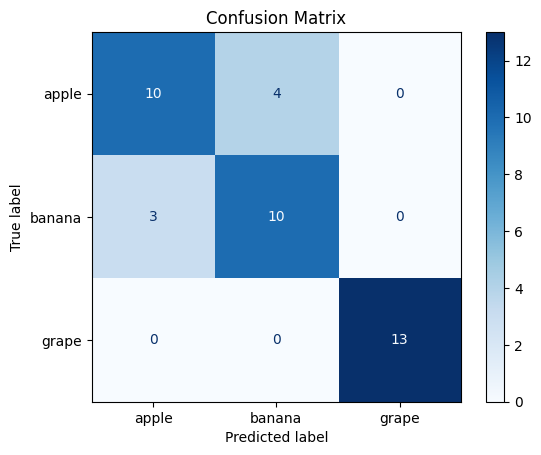

In [125]:
y_pred_DT = final_model_DT.predict(X_test)
print(classification_report(y_test, y_pred_DT))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_DT)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model_LR.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

The macro-average ROC AUC of 0.96 for LRM shows great overall discriminative ability across all fruit classes. This means that, on average across the three one-vs-rest classifications, the model has a very high probability of ranking true positive instances higher than negative instances. E.g. if you take a random apple and a random non-apple, the LRM has a ~96% chance of giving the apple a higher score than the non-apple. 

In [126]:
# Transform class labels to numbers (0/1) for each class
label_binarizer = LabelBinarizer()
y_test_bin = label_binarizer.fit_transform(y_test)

# Get propabilities
propability_LR = final_model_LR.predict_proba(X_test)
propability_DT = final_model_DT.predict_proba(X_test)

# Calculate Macro-average ROC AUC 
auc_LR = roc_auc_score(y_test_bin, propability_LR, multi_class='ovr', average='macro')
auc_DT = roc_auc_score(y_test_bin, propability_DT, multi_class='ovr', average='macro')

print(f"Logistic Regression Macro-average ROC AUC: {auc_LR:.4f}")
print(f"Decision Tree Macro-average ROC AUC: {auc_DT:.4f}")

Logistic Regression Macro-average ROC AUC: 0.9608
Decision Tree Macro-average ROC AUC: 0.9056


In the graphic, it is visible that the grape recognition is precise in both models, which was also visible in the f1-scores above. While both apple and banana classification achieve identical AUC scores (0.94) for the LRM, indicating equivalent discrimination capability, they exhibit different precision-recall characteristics at the default decision threshold. Apple classification has higher precision, correctly identifying apples but missing some borderline cases that get misclassified as banana, resulting in higher precision but lower recall in apples, and the opposite for bananas. The curves suggest that tweaking the threshold for bananas and apples could improve the True Positive Rate (TPR), without the False Positive Rate (FPR) rising too much. Depending on the use-case of the classifier this could be a viable option.   

The higher AUC for apples (apple: 0.88, banana: 0.84) indicates the Decision Tree has better overall ability to distinguish apples from non-apples across all possible thresholds, but the identical f1-scores show a similar performance at the current threshold. For bananas, the curve only rises slightly the more to the right it goes, this indicates that the TPR cannot be increased without having to accept a higher FPR. For apples, the rise is not as steep, so if it is important to find more apples, it is possible without too many false positives up to a certain point. 

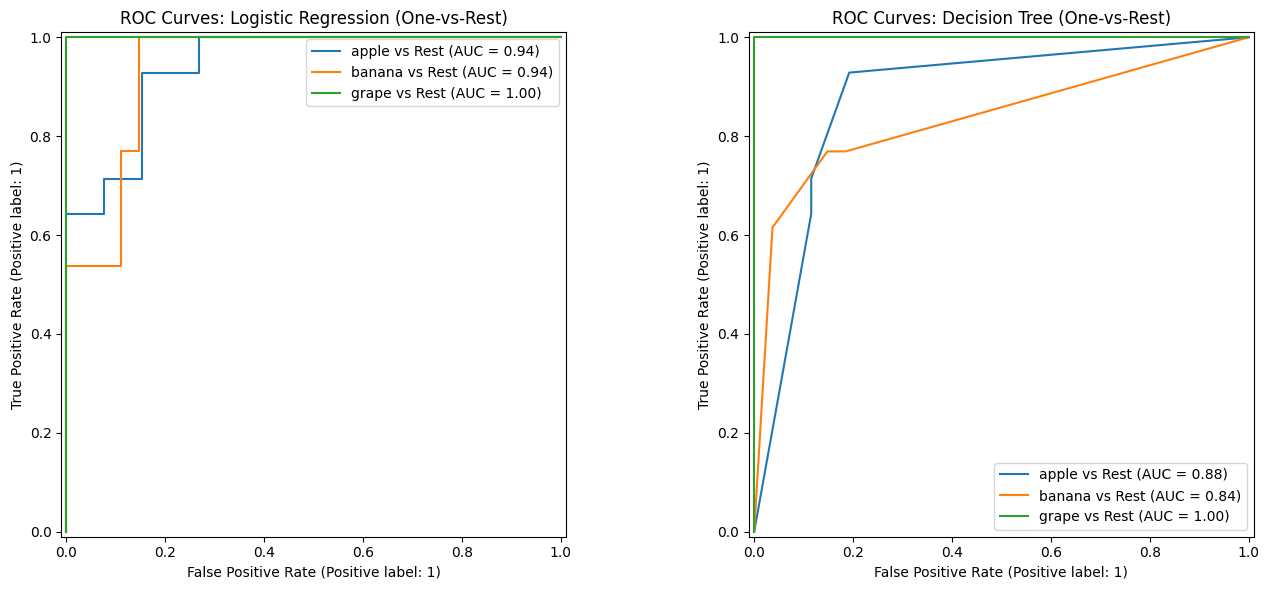

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Logistic Regression
for class_id, class_label in enumerate(label_binarizer.classes_):

    # For each class, get the ROC curve and AUC
    RocCurveDisplay.from_predictions(
        y_test_bin[:, class_id],
        propability_LR[:, class_id],
        name=f"{class_label} vs Rest",
        ax=ax1,
    )
ax1.set_title("ROC Curves: Logistic Regression (One-vs-Rest)")
ax1.legend()

# Plot for Decision Tree
for class_id, class_label in enumerate(label_binarizer.classes_):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, class_id],
        propability_DT[:, class_id],
        name=f"{class_label} vs Rest",
        ax=ax2,
    )
ax2.set_title("ROC Curves: Decision Tree (One-vs-Rest)")
ax2.legend()

plt.tight_layout()
plt.show()

# Conclusion
Both models perform similarly in terms of accuracy but differ regarding the other performance metrics. Depending on the use-case one model could be better than the other, e.g. if it is crucial that fruit recognized as apple really is an apple, the LRM would be the better choice (at default threshold), but if a perfect grape detection is important or the explainability of Decision Tree is needed, the DTM would be better.   
The Logistic Regression Model has a higher AUC, which means that without knowing a specific goal for the classifier, the LRM is generally the safer choice because it is better a distinguishing between all classes and across different thresholds. This higher discriminative ability makes it more robust for general-purpose applications where the optimal operating point is unknown. If a specific purpose is known, both models could be improved for the specific area by changing the threshold.

# References
[1] ‘Data Preprocessing in Python’, GeeksforGeeks, Oct. 29, 2017. Available: https://www.geeksforgeeks.org/machine-learning/data-preprocessing-machine-learning-python/. [Accessed: Oct. 11, 2025]  

[2] J. Britton, ‘Classification Basics: Walk-through with the Iris Data Set’, Towards Data Science, Jul. 27, 2020. Available: https://towardsdatascience.com/classification-basics-walk-through-with-the-iris-data-set-d46b0331bf82/. [Accessed: Oct. 11, 2025]  

[3] „LogisticRegression“, scikit-learn. Available: https://scikit-learn/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. [Accessed: Oct. 19, 2025]

